# Demo of PyMacrospin

## 1. Basic PyMacrospin Example ##

Consider the case of a single macrospin in the presence of only an external field of 1 kOe along the $\hat{y}$ axis. The moment is initially along $\hat{x}$. The moment will rotate to align with the external field based on the Landau-Lifshitz-Gilbert (LLG) equation.

In [1]:
import sys, importlib
sys.path.append("../")

In [3]:
import numpy as np
import pymacrospin.parameters as params
from pymacrospin import plot
import pymacrospin.numba.kernels as kernels
# import pymacrospin.kernels as kernels # Use this if you want core Python engine

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Setting up the kernel ###

In [7]:
importlib.reload(kernels)

<module 'pymacrospin.numba.superkernels' from '../pymacrospin/numba/superkernels.py'>

In [6]:
parameters = {
    'Ms': 140, # Saturation Magnetization (emu/cc)
    'dt': 1e-12, # Timestep (sec)
    'damping': 0.01, # Gilbert damping
    'm0': [0.99, 0.01, 0.01], # Initial moment (normalized)
}

In [7]:
kernel = kernels.Kernel(**parameters)

### Running the kernel ###
Now the kernel is ready to be used. The simulations are run for 10 ns, and then the results are plotted.

In [8]:
kernel.reset()
kernel.Hext = [0,1e3,0] # External field (Oe) along y-direction
times1, moments1 = kernel.run(10e-9, num_points=1000)

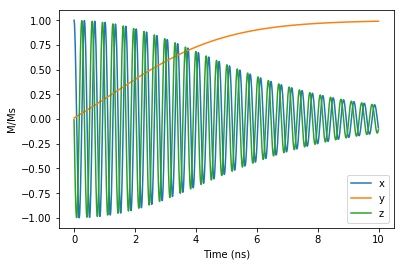

In [9]:
plt.plot(times1*1e9, moments1[:,0], label='x')
plt.plot(times1*1e9, moments1[:,1], label='y')
plt.plot(times1*1e9, moments1[:,2], label='z')
plt.ylim(-1.1, 1.1)
plt.ylabel("M/Ms")
plt.xlabel("Time (ns)")
plt.legend()
plt.show()

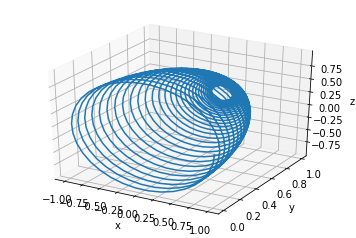

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(moments1[:,0], moments1[:,1], moments1[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

The moment is seen to rotate to point along the $\hat{y}$ direction of the external field as expected.

#### Energy surface

We examine the energy on the unit sphere. Without spin torques, the moment should relax towards a local minimum.

In [11]:
ms, energies = kernel.energy_surface()

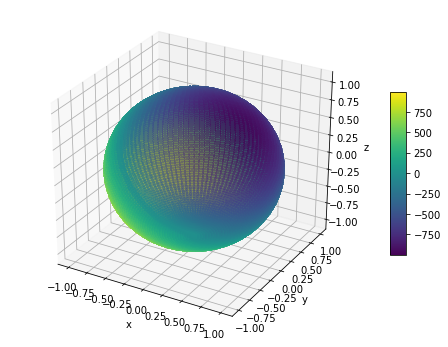

In [12]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
# Plot the surface.
surf = ax.scatter3D(ms[:,0], ms[:,1], ms[:,2], s=30, c=energies,
                       linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

#### Torque surface

We examine the torque on the unit sphere. The moment should move along the torque "flow".

In [13]:
ms, torques = kernel.torque_surface(points=10)

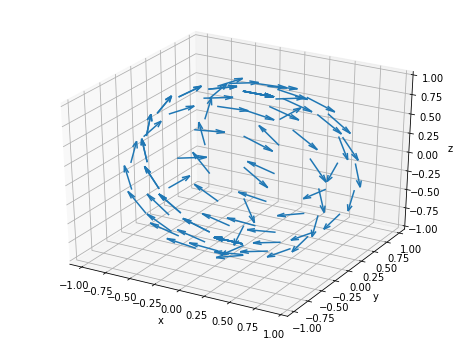

In [14]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
# Plot the surface.
ax.quiver(ms[:,0], ms[:,1], ms[:,2], torques[:,0], torques[:,1], torques[:,2],
         length=0.3, normalize=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

As expected, the moment moves in a clockwise spiral.

### Continuing the simulation ###
The kernel can continue where it left off. Below, the kernel is run for another 10ns and plotted.

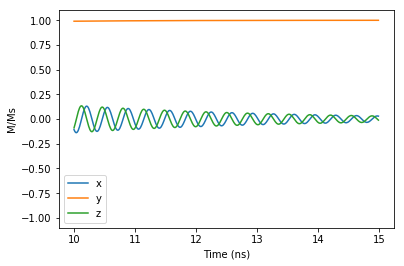

In [15]:
times2, moments2 = kernel.run(5e-9,num_points=500)
plt.plot(times2*1e9, moments2[:,0], label='x')
plt.plot(times2*1e9, moments2[:,1], label='y')
plt.plot(times2*1e9, moments2[:,2], label='z')
plt.ylim(-1.1, 1.1)
plt.ylabel("M/Ms")
plt.xlabel("Time (ns)")
plt.legend()
plt.show()

Since the moment has been stable since roughly 12 ns, the orientation does not change much.

### Resetting the kernel ###
The kernel can be reset to use its initial conditions with the `reset` method. The simulations are re-started from $t=0$.

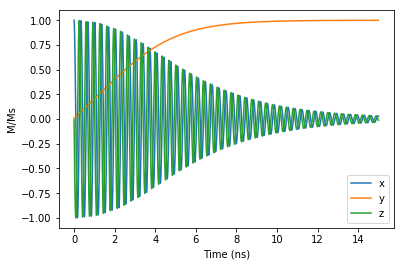

In [16]:
kernel.reset()
times3, moments3 = kernel.run(15e-9,num_points=1000)
plt.plot(times3*1e9, moments3[:,0], label='x')
plt.plot(times3*1e9, moments3[:,1], label='y')
plt.plot(times3*1e9, moments3[:,2], label='z')
plt.ylim(-1.1, 1.1)
plt.ylabel("M/Ms")
plt.xlabel("Time (ns)")
plt.legend()
plt.show()

### Running the stabilize method
When the moment orientation in equilibrium is of more interest than the time dependent behavior of the moment, the `relax` or `stabilize` method can be used to run the simulation until the orientation has stabilized. Both come with the option to specify the maximum time `max_time` to avoid perpetual precession.

* `relax` method: Stability is measured by the energy variation within a specified threshold `precision`.
* `stabilize` method: Stability is measured by the magnitude of the moment variation $\Delta m$. The default threshold is `1e-3`, which has been found experimentally to work well.

#### Relax method ####

In [17]:
kernel.reset()
kernel.relax(precision=1e-3,max_time=1e-7)

In [18]:
kernel.m

array([ 0.02679457,  0.99909765, -0.03295324], dtype=float32)

The kernel moment is observed to point along the $\hat{y}$ direction.

In [19]:
kernel.t_sec

1.3e-08

Stability has been achieved at $t=13$ ns.

#### Stabilize method ####

In [20]:
kernel.reset()
kernel.stabilize(threshold=1e-3,max_time=100e-9)

In [21]:
kernel.m

array([ 0.02679457,  0.99909765, -0.03295324], dtype=float32)

The kernel moment is observed to point along the $\hat{y}$ direction.

In [22]:
kernel.t_sec

1.3999999999999998e-08

## 2. Add Demagnization field

We add the demagnetization field induced by the shape anisotropy of the sample.

In [23]:
from pymacrospin import demag

In [24]:
# Consider a cylinder
length = 200e-7 # cm - major axis
width = 100e-7 # cm - minor axis
height = 5e-7 # cm - height

Nd = demag.cylinder(length, width, height, cgs=True)
Nd

array([ 0.35101844,  0.9185402 , 11.29681198])

In [25]:
# Add demag effect into the kernel
kernel.add_demag(Nd)

In [26]:
# Test run
kernel.reset()
times, moments = kernel.run(20e-9, num_points=2000)

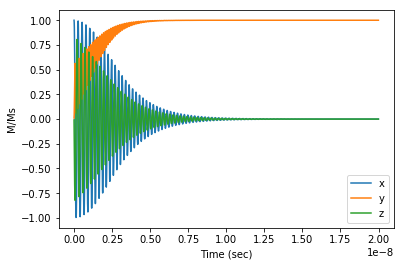

In [27]:
plot.moment_time_domain(times, moments)
plt.show()

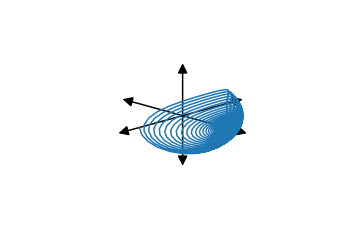

In [28]:
ax = plot.moment_3d(moments)
plt.show()

### Linear field sweep
An important signature of uniaxial anisotropy is the hysteresis of the magnetoresistance trace. We can readily show that by sweeping the external field in from $-x$ to $+x$ then backward.

Note that when sweeping the field, we should intentionally introduce some angle deviation so that the applied field won't be completely parallel/antiparallel to the relaxed moment.

In [29]:
import pymacrospin.simulations as sims

In [30]:
simulation = sims.FieldSweep(kernel)

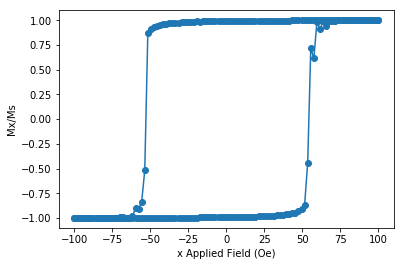

In [33]:
fields, moments, times = simulation.sweep_linear([1e2,10,0],[-1e2,10,0],100,return_time=True)

plt.plot(fields[:,0], moments[:,0], 'o-')
# plt.ylim(-1.1, 1.1)
plt.ylabel("Mx/Ms")
plt.xlabel("x Applied Field (Oe)")
plt.show()

Hysteresis is clearly seen.

### Rotational field sweep
Rotate the field in-plane.

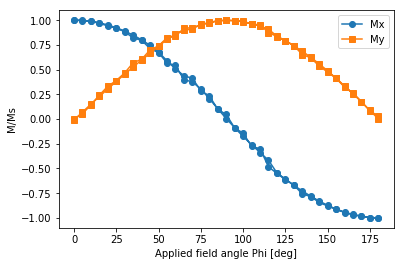

In [44]:
phis = np.linspace(0,180,37)
fields, moments, times = simulation.sweep_rotation(1000,90,phis,return_time=True,reverse=True)

xdata = np.concatenate([phis,phis[::-1]])
plt.plot(xdata, moments[:,0], 'o-',label="Mx")
plt.plot(xdata, moments[:,1], 's-',label="My")
plt.ylim(-1.1, 1.1)
plt.ylabel("M/Ms")
plt.xlabel("Applied field angle Phi [deg]")
plt.legend()
plt.show()

When the field is strong, 1000 Oe, we don't see the effect of the demag field. Let's lower the field.

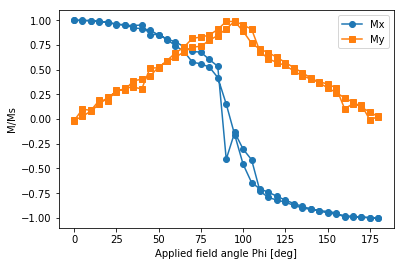

In [43]:
phis = np.linspace(0,180,37)
fields, moments, times = simulation.sweep_rotation(100,90,phis,return_time=True,reverse=True)

xdata = np.concatenate([phis,phis[::-1]])
plt.plot(xdata, moments[:,0], 'o-',label="Mx")
plt.plot(xdata, moments[:,1], 's-',label="My")
plt.ylim(-1.1, 1.1)
plt.ylabel("M/Ms")
plt.xlabel("Applied field angle Phi [deg]")
plt.legend()
plt.show()

Distortion is seen, as expected for low field.

## 3. Add Uniaxial Anisotropy ##

We add uniaxial crystalline anisotropy to the sample.

In [45]:
u = [0, 0, 1] # Uniaxial anisotropy unit vector along z axis
Ku1 = 40 # 1st Uniaxial Anisotropy energy (erg/cc)
Ku2 = 1 # 2nd Uniaxial Anisotropy energy (erg/cc)

kernel.add_uniaxial_anisotropy(u, Ku1, Ku2)

In [48]:
kernel.Hext = [0,1e3,0]
kernel.reset()
times, moments = kernel.run(20e-9, num_points=2000)

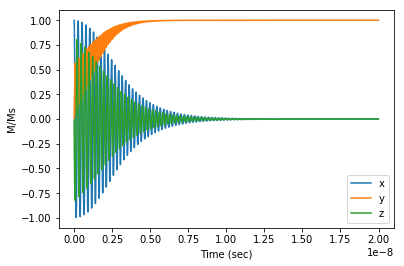

In [49]:
plot.moment_time_domain(times, moments)
plt.show()

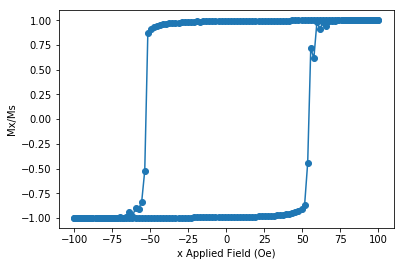

In [51]:
fields, moments, times = simulation.sweep_linear([1e2,10,0],[-1e2,10,0],100,return_time=True)

plt.plot(fields[:,0], moments[:,0], 'o-')
# plt.ylim(-1.1, 1.1)
plt.ylabel("Mx/Ms")
plt.xlabel("x Applied Field (Oe)")
plt.show()

## 4. Add Spin-Torque

We add damping-like spin torque to the sample. Because our sample is quite messy now, let's reset it to the original "clean" state, then add demag and spin torque effects.

In [52]:
kernel.reset_environment()
kernel.add_demag(Nd)
kernel.add_spintorque(np.array([0,1,0],dtype=np.float32),0.6,2,0)

In [77]:
kernel.Hext = [0,0,0] # No external field
kernel.Jc = 1e8

In [81]:
kernel.reset()
print(kernel.m)
times, moments = kernel.run(10e-9, num_points=4000)

[0.99989796 0.01009998 0.01009998]


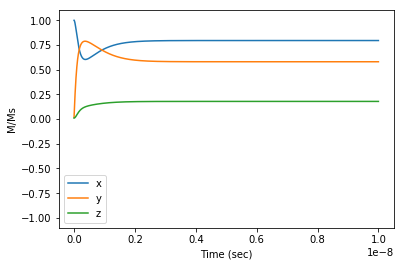

In [82]:
plot.moment_time_domain(times, moments)
# plt.xlim(left=0,right=1e-11)
plt.show()

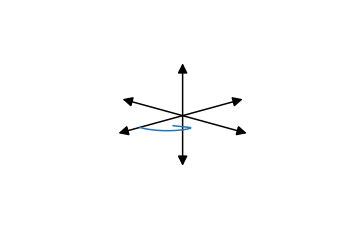

In [83]:
ax = plot.moment_3d(moments)
plt.show()

In [84]:
ms, energies = kernel.energy_surface()

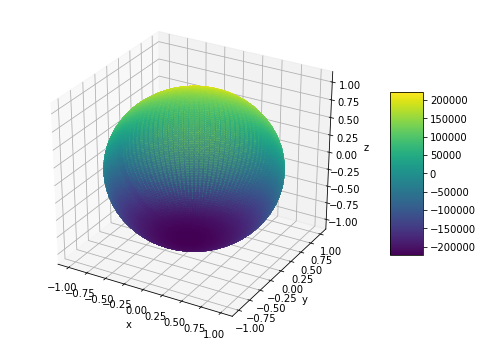

In [85]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
# Plot the surface.
surf = ax.scatter3D(ms[:,0], ms[:,1], ms[:,2], s=30, c=energies,
                       linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [86]:
ms, torques = kernel.torque_surface(points=10)

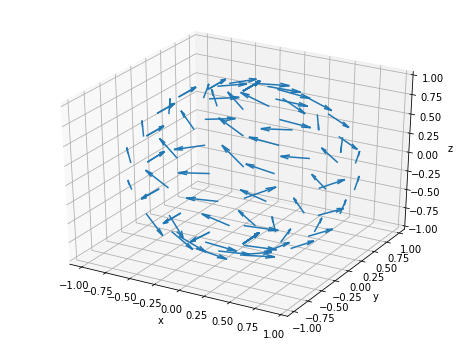

In [87]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
# Plot the surface.
ax.quiver(ms[:,0], ms[:,1], ms[:,2], torques[:,0], torques[:,1], torques[:,2],
         length=0.3, normalize=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

#### Current sweep

We can sweep current to observe current switching

In [92]:
simJ = sims.CurrentSweep(kernel)

In [89]:
kernel.reset_environment()
kernel.add_demag(Nd)
kernel.add_spintorque(np.array([1,0,0],dtype=np.float32),0.6,2,0)

In [137]:
kernel.Hext = [0,50,0] # External field to tilt the moment off x-axis

In [138]:
currs, moments = simJ.sweep_linear(3e8,-3e8,100)

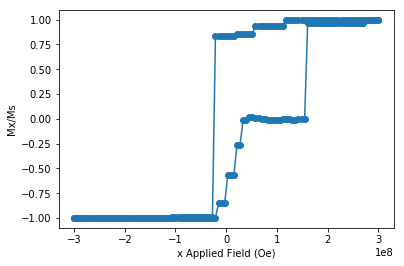

In [139]:
plt.plot(currs, moments[:,0], 'o-')
# plt.ylim(-1.1, 1.1)
plt.ylabel("Mx/Ms")
plt.xlabel("x Applied Field (Oe)")
plt.show()

Current switching hysteresis is seen, as expected from the demag field.